In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['home-credit-default-risk']
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [28]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Embedding Neural Network ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Embedding Neural Network Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.show()

In [29]:
def preprocessing(input_dir, debug=False):
    # No target encoding
    num_rows = 10000 if debug else None
    
    print('Preprocessing started.')
    print('Bureau_Balance')
    buro_bal = pd.read_csv(input_dir + 'bureau_balance.csv', nrows=num_rows)
    
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    del buro_bal
    gc.collect()
    
    print('Bureau')
    buro_full = pd.read_csv(input_dir + 'bureau.csv', nrows=num_rows)

    gc.collect()
    
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    
    del buro_full
    gc.collect()
    
    print('Previous_Application')
    prev = pd.read_csv(input_dir + 'previous_application.csv', nrows=num_rows)
    
    prev_cat_features = [
        f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    ]
    
    
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    del prev
    gc.collect()
    
    print('POS_CASH_Balance')
    pos = pd.read_csv(input_dir + 'POS_CASH_balance.csv', nrows=num_rows)
    
    
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_pos = pos.groupby('SK_ID_CURR').mean()
    
    del pos, nb_prevs
    gc.collect()
    
    print('Credit_Card_Balance')
    cc_bal = pd.read_csv(input_dir + 'credit_card_balance.csv', nrows=num_rows)

    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
    
    del cc_bal, nb_prevs
    gc.collect()
    
    print('Installments_Payments')
    inst = pd.read_csv(input_dir + 'installments_payments.csv', nrows=num_rows)
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
    
    print('Train/Test')
    data = pd.read_csv(input_dir + 'application_train.csv', nrows=num_rows)
    test = pd.read_csv(input_dir + 'application_test.csv', nrows=num_rows)
    print('Shapes : ', data.shape, test.shape)
        
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()
    
    print('Preprocessing done.')

    return data, test

In [30]:
train, test = preprocessing('../input/home-credit-default-risk/', debug=False)

Preprocessing started.
Bureau_Balance
Bureau
Previous_Application
POS_CASH_Balance
Credit_Card_Balance
Installments_Payments
Train/Test
Shapes :  (307511, 122) (48744, 121)
Preprocessing done.


In [31]:
# Drop the target and the ID
X_train, y_train = train.iloc[:,2:], train.TARGET
X_test = test.iloc[:,1:]

In [32]:
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}

In [33]:
nb_numeric   = len(X_train.columns) - len(col_vals_dict)
nb_categoric = len(col_vals_dict)
print('Number of Numerical features:', nb_numeric)
print('Number of Categorical features:', nb_categoric)

Number of Numerical features: 173
Number of Categorical features: 16


In [34]:
# Store the labels of each features
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}

In [36]:
# Generator to parse the cat
generator = (c for c in X_train.columns if X_train[c].dtype == object)

# Label Encoder
for c in generator:
    lbl = LabelEncoder()
    lbl.fit(list(X_train[c].values) + list(X_test[c].values))
    X_train[c] = lbl.transform(list(X_train[c].values))
    X_test[c] = lbl.transform(list(X_test[c].values))

In [37]:
embed_cols = []
len_embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        len_embed_cols.append(len(col_vals_dict[c]))
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions
        
print('\n Number of embed features :', len(embed_cols))

CODE_GENDER: 3 values
NAME_TYPE_SUITE: 8 values
NAME_INCOME_TYPE: 8 values
NAME_EDUCATION_TYPE: 5 values
NAME_FAMILY_STATUS: 6 values
NAME_HOUSING_TYPE: 6 values
OCCUPATION_TYPE: 19 values
WEEKDAY_APPR_PROCESS_START: 7 values
ORGANIZATION_TYPE: 58 values
FONDKAPREMONT_MODE: 5 values
HOUSETYPE_MODE: 4 values
WALLSMATERIAL_MODE: 8 values
EMERGENCYSTATE_MODE: 3 values

 Number of embed features : 13


In [38]:
def build_embedding_network(len_embed_cols):
    
    model_out = []
    model_in  = []
    
    for dim in len_embed_cols:
        input_dim = Input(shape=(1,), dtype='int32')
        embed_dim = Embedding(dim, dim//2, input_length=1)(input_dim)
        embed_dim = Dropout(0.25)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(176,), dtype='float32')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(128))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.35))(outputs)
    outputs = (Dense(64))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(32))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [39]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

In [40]:
proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train, X_train, X_test)
print('Length of the list:', len(proc_X_train_f))

Length of the list: 14


In [41]:
proc_X_train_f

[array([1, 0, 1, ..., 0, 0, 0]),
 array([6, 1, 6, ..., 6, 6, 6]),
 array([7, 4, 7, ..., 7, 1, 1]),
 array([4, 1, 4, ..., 1, 4, 1]),
 array([3, 1, 3, ..., 2, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([ 8,  3,  8, ..., 10,  8,  8]),
 array([6, 1, 1, ..., 4, 6, 4]),
 array([ 5, 39, 11, ..., 39,  3,  5]),
 array([3, 3, 0, ..., 3, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([5, 0, 7, ..., 4, 5, 4]),
 array([0, 0, 2, ..., 0, 0, 0]),
 array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         -3.15421053e+02,  1.15592471e+04,  1.15592471e+04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.38532000e+03,  6.47545860e+04,  6.47545860e+04],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         -7.61666667e+02,  7.09615500e+03,  7.09615500e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         -2.38742857e+03,  4.39970786e+03,  4.11591536e+03],
        [ 0.00000000e+00,  0.00000000e+00,

In [42]:
print(proc_X_train_f[12].shape)

(307511,)


In [43]:
del proc_X_train_f, proc_X_val_f, proc_X_test_f
gc.collect()

110

In [44]:
num_cols = [x for x in X_train.columns if x not in embed_cols]


# Impute missing values in order to scale
X_train[num_cols] = X_train[num_cols].fillna(value = 0)
X_test[num_cols] = X_test[num_cols].fillna(value = 0)

# Fit the scaler only on train data
scaler = MinMaxScaler().fit(X_train[num_cols])
X_train.loc[:,num_cols] = scaler.transform(X_train[num_cols])
X_test.loc[:,num_cols] = scaler.transform(X_test[num_cols])

In [48]:
K = 5
runs_per_fold = 1
n_epochs = 250
patience = 10

cv_aucs   = []
full_val_preds = np.zeros(np.shape(X_train)[0])
y_preds = np.zeros((np.shape(X_test)[0],K))

kfold = StratifiedKFold(n_splits = K,  
                            shuffle = True, random_state=1)

for i, (f_ind, outf_ind) in enumerate(kfold.split(X_train, y_train)):

    X_train_f, X_val_f = X_train.loc[f_ind].copy(), X_train.loc[outf_ind].copy()
    y_train_f, y_val_f = y_train[f_ind], y_train[outf_ind]
    
    X_test_f = X_test.copy()
    
    
    # Shuffle data
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f.iloc[idx]
    
    #preprocessing
    proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train_f, X_val_f, X_test_f)
    
    #track oof prediction for cv scores
    val_preds = 0
    
    for j in range(runs_per_fold):
    
        NN = build_embedding_network(len_embed_cols)

        # Set callback functions to early stop training and save the best model so far
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]

        NN.fit(proc_X_train_f, y_train_f.values, epochs=n_epochs, batch_size=4096, verbose=1,callbacks=callbacks,validation_data=(proc_X_val_f, y_val_f))
        
        val_preds += NN.predict(proc_X_val_f)[:,0] / runs_per_fold
        y_preds[:,i] += NN.predict(proc_X_test_f)[:,0] / runs_per_fold
        
    full_val_preds[outf_ind] += val_preds
        
    cv_auc  = roc_auc_score(y_val_f.values, val_preds)
    cv_aucs.append(cv_auc)
    print ('\nFold %i prediction cv AUC: %.5f\n' %(i,cv_auc))
    
print('Mean out of fold AUC: %.5f' % np.mean(cv_auc))
print('Full validation AUC: %.5f' % roc_auc_score(y_train.values, full_val_preds))

Epoch 1/250
61/61 [==============================] - 5s 45ms/step - loss: 0.3961 - val_loss: 0.2727
Epoch 2/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2788 - val_loss: 0.2601
Epoch 3/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2653 - val_loss: 0.2560
Epoch 4/250
61/61 [==============================] - 2s 31ms/step - loss: 0.2619 - val_loss: 0.2539
Epoch 5/250
61/61 [==============================] - 2s 31ms/step - loss: 0.2578 - val_loss: 0.2543
Epoch 6/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2563 - val_loss: 0.2526
Epoch 7/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2563 - val_loss: 0.2532
Epoch 8/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2579 - val_loss: 0.2530
Epoch 9/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2557 - val_loss: 0.2519
Epoch 10/250
61/61 [==============================] - 2s 32ms/step - loss: 0.2522 - val_loss: 0.2524

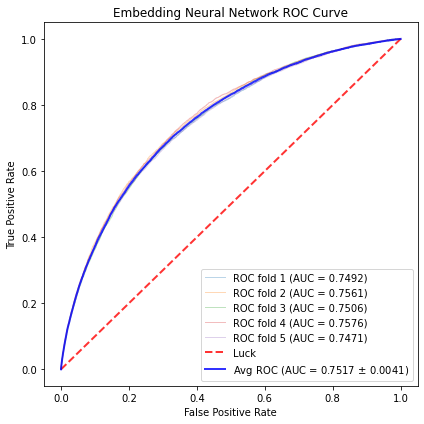

In [49]:
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in kfold.split(X_train, y_train)]
display_roc_curve(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

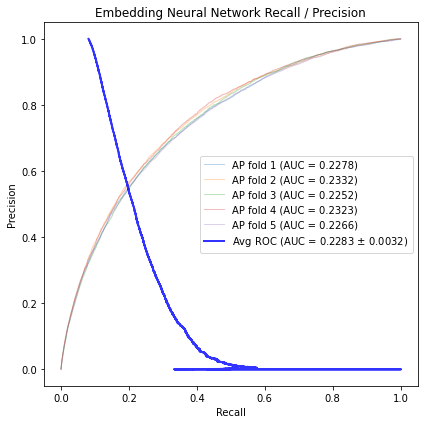

In [50]:
display_precision_recall(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

In [51]:
test['TARGET'] = np.mean(y_preds, axis=1)
test = test[['SK_ID_CURR', 'TARGET']]
out_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': test['TARGET']})
out_df.to_csv('nn_embedding_submission.csv', index=False)